In [316]:
import quandl
import datetime
import cpi
from matplotlib import style
import os
# from sklearn.svm import ???

In [317]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression

## WARNING!

`cpi.update()` is a heavy function that updates the entire CPI package and is very bloaty and unnecessary! 

**Uncomment and run if absolutely needed!**

In [318]:
# cpi.update()

In [319]:
#import API key
from SECRET_KEY import quandel_key
quandel_key

'qrznzr7vcG1HMd7ae2E7'

In [320]:
style.use('ggplot')

In [321]:
df = quandl.get("WIKI/XOM", api_key=quandel_key)

df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1970-01-02,61.75,62.00,61.62,62.00,36700.0,0.0,1.0,0.740936,0.743936,0.739376,0.743936,1174400.0
1970-01-05,62.00,63.00,61.87,63.00,58800.0,0.0,1.0,0.743936,0.755935,0.742376,0.755935,1881600.0
1970-01-06,63.00,63.13,62.25,62.87,38500.0,0.0,1.0,0.755935,0.757495,0.746936,0.754375,1232000.0
1970-01-07,62.87,62.87,62.38,62.50,28700.0,0.0,1.0,0.754375,0.754375,0.748496,0.749935,918400.0
1970-01-08,62.50,63.00,62.25,62.62,33600.0,0.0,1.0,0.749935,0.755935,0.746936,0.751375,1075200.0


In [322]:
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

In [323]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

In [324]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
1970-01-02,0.743936,0.612903,0.404858,1174400.0,0.674942
1970-01-05,0.755935,1.793651,1.612903,1881600.0,0.659943
1970-01-06,0.754375,1.399714,-0.206349,1232000.0,0.656943
1970-01-07,0.749935,0.784000,-0.588516,918400.0,0.656943
1970-01-08,0.751375,1.197700,0.192000,1075200.0,0.655384


In [325]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)



In [326]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
1970-01-02,0.743936,0.612903,0.404858,1174400.0,0.674942
1970-01-05,0.755935,1.793651,1.612903,1881600.0,0.659943
1970-01-06,0.754375,1.399714,-0.206349,1232000.0,0.656943
1970-01-07,0.749935,0.784000,-0.588516,918400.0,0.656943
1970-01-08,0.751375,1.197700,0.192000,1075200.0,0.655384


In [327]:
X = np.array(df.drop(['label'], 1))
X = scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [328]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)

In [329]:
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

In [330]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day



In [331]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]



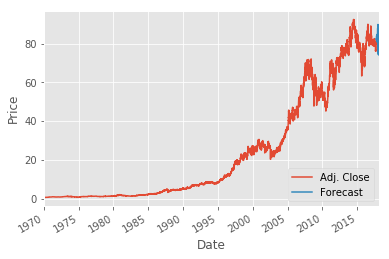

In [332]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


# ************** START OF THE RESEARCH*********************

My Course of Action:

1) Create an index for companies that could project how lyft should function. 

2) Create a function to do the these steps to a single stock
    - Import first 261 days (1 fiscal year) of stock prices for each stock
    - keep the Open, High, Low, Close, Volume, Ex-Dividend for each stock in the dataframe
    - Adjust for inflation using easy money
    - create a column to isolate the month for seasionality
    - number each instance by # of day in the year
    - Save to a .csv in the /data directory
    
3) Create a function to Graph a given dataframe

4) Create a fucntion to merge the datasets together. 

5) Normalize the full DS

6) Instaniate a linuar regression model and train it with the overall data

7) Use what Lyft stock data we have to predict to test the first year of Lyft IPO

8) Make some sexy visuals from the prediction 

9) Analize the accuracy of the model

10) Create alternative indexes and repeat this process for all of them.  


In [333]:
# 1) create an index for tech stocks that might behave like Lyft
tech_index = ['TWTR', 'GOOGL', 'FB', 'AMZN', 'SPLK', 'PYPL', 'YHOO', 'DBX']

In [334]:
#Create an index for transportation companies:
# Picked three top and bottom preforming stocks from DJTransportation index:
#  https://www.marketwatch.com/investing/index/djt

transportation_index= ['MATX', 'LUV', 'JBLU', 'CAR', 'FDX', 'ALK']

In [335]:
#Write a function to combine multiple indexes
def super_index(index_a, index_b):
    super_index = index_a
    for i in index_b:
        super_index.append(i)
    return super_index
    

In [336]:
# combiend index
cmb_index = super_index(tech_index, transportation_index)

In [338]:
#     my_data_dict = {"years": list(),
#                     "months": list()}
    
#     for item in df["Date"]:
#         my_data_dict["years"].append(item.year)
#         my_data_dict["months"].append(item.month)

In [520]:
# Create map of DJIA and import it into the stock column
djia=pd.read_csv('data/DJIA.csv')
djia.columns =['Date', "DJIA"]

In [521]:
djia.head()

,Date,DJIA
0,2016-04-15,17897.46
1,2016-04-14,17926.43
2,2016-04-13,17908.28
3,2016-04-12,17721.25
4,2016-04-11,17556.41


In [543]:
def import_process_stock(stock): #Stock is a stock code string
    """Uploads the data from Quandl and runs through the various 
        processes to get the data we want adjusted for inflation. 
        once data is processed it saves to a .csv and returns data in a dataframe
        if local .csv of stock data exists it returns that data as a dataframe"""
    # Check to see if stock is in the data and open the .csv if it is
    
#     if os.path.isfile("data/"+stock+".csv"):
#         df= pd.read_csv("data/"+stock+".csv")
#         return df
    
    df = quandl.get(("WIKI/"+stock), api_key=quandel_key)
#     - keep the Open, High, Low, Close, Volume, Ex-Dividend for each stock in the dataframe
    df = df[['Open','High','Low','Close','Volume','Ex-Dividend']]
    #Import first 261 days 
#     (1 fiscal year) of stock prices for each stock
    df = df.iloc[:261]   
    #Bring the timeserise index into the datafraem
    df=df.reset_index()
    #Add day and month numbers to time serise
    df['d_number'] = range(1, len(df)+1)
#   create a column to isolate the month for seasionality
    df['Year'], df['Month'] = 0,0
    my_data_dict = {"years": list(),
                    "months": list()}
    
    for item in df["Date"]:
        my_data_dict["years"].append(int(item.year))
        my_data_dict["months"].append(int(item.month))

    df["Year"] = my_data_dict["years"]
    df["Month"] = my_data_dict["months"]

    
    #improt DJIA data:
    df.Date = df.Date.dt.strftime('%Y-%m-%d')
    df = df.merge(djia, how='outer', on='Date')
    df = df.iloc[:261] 

    
    # Adjust for inflation using CPI************************
    inflated_closing_vals = list()
    for index, year in enumerate(df["Year"].astype(int)):
        inflated_closing_vals.append(round(cpi.inflate(df["Close"].iloc[index], year, to=2018), 2))
    df["inflation_close"] = inflated_closing_vals
    
#     df["inflation_index"] = cpi.inflate(1, , to=2018)
#     df["Close"] = df["Close"]*df["inflation_index"]
    #*******************************************************
    
    # rearange table
    df=df[["Date","d_number", "Month", "Year", "Volume", "Open", "High", "Low", "Close","DJIA","inflation_close"]]
#     - Save to a .csv in the /data directory
    df.to_csv("data/"+stock+".csv")


    return df

In [544]:
test = import_process_stock(tech_index[0])
test.head()

,Date,d_number,Month,Year,Volume,Open,High,Low,Close,DJIA,inflation_close
0,2013-11-07,1.0,11.0,2013.0,117701600.0,45.10,50.09,44.00,44.90,15593.98,48.40
1,2013-11-08,2.0,11.0,2013.0,27925300.0,45.93,46.94,40.69,41.65,15761.78,44.90
2,2013-11-11,3.0,11.0,2013.0,16113900.0,40.50,43.00,39.40,42.90,15783.10,46.24
3,2013-11-12,4.0,11.0,2013.0,6316700.0,43.66,43.78,41.83,41.90,15750.67,45.16
4,2013-11-13,5.0,11.0,2013.0,8688300.0,41.03,42.87,40.76,42.60,15821.63,45.92


## merge djia with test dataframe


In [476]:
djia.count()

Date     32601
Value    32601
dtype: int64

In [479]:
test.count()

Date        261
d_number    261
Month       261
Year        261
Volume      261
Open        261
High        261
Low         261
Close       261
inflated    261
dtype: int64

1. Create Sets to Hold Unique Dates for Both Sub-DFs
2. Check How Many Dates Overlap Using Subset Matching

In [502]:
djia_unique_dates, test_unique_dates = set(), set()

for djia_date in djia["Date"]:
    djia_unique_dates.add(djia_date)
    for test_date in test["Date"]:
        test_unique_dates.add(test_date)

## ISSUE: Date Types are Different Across Subsets Causing Incorrect Set Mismatch!

In [509]:
# should return set of len > 0 (exp. ~261)
subset_dates = djia_unique_dates.intersection(test_unique_dates)

djia_subset = djia[djia["Date"] in subset_dates]

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [501]:
# attempting to turn nasty Timestamps into nice strings
# WARNING: ONLY RUN ONCE IF FEATURE DATA IS IN TYPE `pd.DateTime64`

test.Date = test.Date.dt.strftime('%Y-%m-%d')

In [ ]:
pd.merge(df2, df1, how='outer', on='month')

In [506]:
test.merge(djia, how='outer', on='Date')

,Date,d_number,Month,Year,Volume,Open,High,Low,Close,inflated,Value
0,2013-11-07,1.0,11.0,2013.0,117701600.0,45.10,50.09,44.00,44.90,1.077911,15593.98
1,2013-11-08,2.0,11.0,2013.0,27925300.0,45.93,46.94,40.69,41.65,1.077911,15761.78
2,2013-11-11,3.0,11.0,2013.0,16113900.0,40.50,43.00,39.40,42.90,1.077911,15783.10
3,2013-11-12,4.0,11.0,2013.0,6316700.0,43.66,43.78,41.83,41.90,1.077911,15750.67
4,2013-11-13,5.0,11.0,2013.0,8688300.0,41.03,42.87,40.76,42.60,1.077911,15821.63
5,2013-11-14,6.0,11.0,2013.0,11099400.0,42.34,45.67,42.24,44.69,1.077911,15876.22
6,2013-11-15,7.0,11.0,2013.0,8010600.0,45.25,45.27,43.43,43.98,1.077911,15961.70
7,2013-11-18,8.0,11.0,2013.0,12810600.0,43.50,43.95,40.85,41.14,1.077911,15976.02
8,2013-11-19,9.0,11.0,2013.0,7436600.0,41.39,41.90,40.00,41.75,1.077911,15967.03
9,2013-11-20,10.0,11.0,2013.0,5767300.0,41.40,41.75,40.51,41.05,1.077911,15900.82


In [531]:
year = 2018

test['inflated']= cpi.inflate(1,year, to=2018)

In [532]:
test.head()

,Date,d_number,Month,Year,Volume,Open,High,Low,Close,DJIA,inflated
0,2013-11-07,1.0,11.0,2013.0,117701600.0,45.10,50.09,44.00,44.90,15593.98,1
1,2013-11-08,2.0,11.0,2013.0,27925300.0,45.93,46.94,40.69,41.65,15761.78,1
2,2013-11-11,3.0,11.0,2013.0,16113900.0,40.50,43.00,39.40,42.90,15783.10,1
3,2013-11-12,4.0,11.0,2013.0,6316700.0,43.66,43.78,41.83,41.90,15750.67,1
4,2013-11-13,5.0,11.0,2013.0,8688300.0,41.03,42.87,40.76,42.60,15821.63,1


In [ ]:
def graph_df(df):
    """"Graphs the closeing prie of a DF"""
    df["Close"].plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()
    
    ##WHY THE FUCK IS IT PLOTING THE D_NUMBER INSTED OF DATE? WHAT THE FLYING FUCK!!

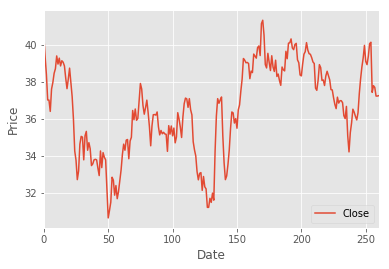

In [418]:
graph_df(test)

In [419]:
test.merge(djia, how='left',on='Date')

### GOAL: Isolate `Month` and `Year` from `pd.Timestamp` objects!

NOTE: Can be improved (three for loops === **BAD**). 

Can use iterator/generator or improved list comp?

In [374]:
my_data_dict = {"years": list(),
                "months": list()}

for item in test["Date"]:
    my_data_dict["years"].append(item.year)
    my_data_dict["months"].append(item.month)

test["Year"] = my_data_dict["years"]
test["Month"] = my_data_dict["months"]

In [375]:
test.head()

,Date,d_number,Month,Year,Volume,Open,High,Low,Close
0,2013-11-07,1,11.0,2013.0,117701600.0,45.10,50.09,44.00,44.90
1,2013-11-08,2,11.0,2013.0,27925300.0,45.93,46.94,40.69,41.65
2,2013-11-11,3,11.0,2013.0,16113900.0,40.50,43.00,39.40,42.90
3,2013-11-12,4,11.0,2013.0,6316700.0,43.66,43.78,41.83,41.90
4,2013-11-13,5,11.0,2013.0,8688300.0,41.03,42.87,40.76,42.60


In [376]:
test.describe()

,d_number,Month,Year,Volume,Open,High,Low,Close
count,261.00000,9.0,9.0,2.610000e+02,261.000000,261.000000,261.000000,261.000000
mean,131.00000,11.0,2013.0,2.389483e+07,46.938103,47.930530,45.859569,46.858046
std,75.48841,0.0,0.0,1.740789e+07,8.990773,9.237592,8.707699,8.981807
min,1.00000,11.0,2013.0,4.107000e+06,30.940000,31.200000,29.510000,30.500000
25%,66.00000,11.0,2013.0,1.251240e+07,40.470000,41.170000,39.700000,40.310000
50%,131.00000,11.0,2013.0,2.064986e+07,45.470000,46.350000,44.640000,45.330000
75%,196.00000,11.0,2013.0,2.910550e+07,52.750000,54.400000,52.110000,53.000000
max,261.00000,11.0,2013.0,1.347100e+08,72.880000,74.730000,69.130000,73.310000


In [377]:
# test cpi.inflate()
# info at https://github.com/datadesk/cpi

cpi_test= cpi.inflate(100, 1913, to=2018)

cpi_test

2536.434343434343